In [34]:
import pandas as pd
import numpy as np
from astropy.table.scripts.showtable import showtable

pre_option_Data=pd.read_csv("option_data.csv")
option_Data=pre_option_Data[['date','best_bid','best_offer','impl_volatility', 'delta', 'gamma', 'vega', 'theta','symbol','cp_flag','strike_price','exdate']]
sp_price_Data=pd.read_csv("price_data.csv")

C:\Users\yigaa\AppData\Local\Temp\ipykernel_5176\4050219233.py:4: DtypeWarning: Columns (23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  pre_option_Data=pd.read_csv("option_data.csv")


In [35]:
# 将 'date' 列转换为 datetime 类型
sp_price_Data['date'] = pd.to_datetime(sp_price_Data['date'])

# 按日期排序
sp_price_Data = sp_price_Data.sort_values('date').reset_index(drop=True)
#记录前一天的价格
sp_price_Data["S_t_minus_1"]=sp_price_Data['close'].shift(1)
sp_price_Data["S_t"]=sp_price_Data['close']
sp_price_Data["delta_S"]=sp_price_Data['S_t']-sp_price_Data['S_t_minus_1']
# 计算相对于前一天的价格比率(标准化)
sp_price_Data['normalized_price_S'] = sp_price_Data['S_t'] / sp_price_Data['S_t_minus_1']
sp_price_Data["normalized_price_S_delta"]=sp_price_Data["normalized_price_S"]-1
# 处理第一天的归一化价格（由于没有前一天的价格）
sp_price_Data.loc[sp_price_Data.index[0], 'normalized_price_S'] = 1

sp_price_Data

,secid,date,ticker,open,close,return,cfadj,cfret,S_t_minus_1,S_t,delta_S,normalized_price_S,normalized_price_S_delta
0,108105,2004-01-02,SPX,1111.92,1108.48,-0.003094,1,1,NaN,1108.48,NaN,1.000000,NaN
1,108105,2004-01-05,SPX,1108.48,1122.22,0.012395,1,1,1108.48,1122.22,13.74,1.012395,0.012395
2,108105,2004-01-06,SPX,1122.22,1123.67,0.001292,1,1,1122.22,1123.67,1.45,1.001292,0.001292
3,108105,2004-01-07,SPX,1123.67,1126.33,0.002367,1,1,1123.67,1126.33,2.66,1.002367,0.002367
4,108105,2004-01-08,SPX,1126.33,1131.92,0.004963,1,1,1126.33,1131.92,5.59,1.004963,0.004963
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4945,108105,2023-08-25,SPX,4389.38,4405.71,0.006718,1,1,4376.31,4405.71,29.40,1.006718,0.006718
4946,108105,2023-08-28,SPX,4426.03,4433.31,0.006265,1,1,4405.71,4433.31,27.60,1.006265,0.006265
4947,108105,2023-08-29,SPX,4432.75,4497.63,0.014508,1,1,4433.31,4497.63,64.32,1.014508,0.014508
4948,108105,2023-08-30,SPX,4500.34,4514.87,0.003833,1,1,4497.63,4514.87,17.24,1.003833,0.003833


In [36]:
#用sp500的原生资产价格，收盘价？
option_Data['date'] = pd.to_datetime(option_Data['date'])
option_Data=pd.merge(option_Data,sp_price_Data[["date","S_t","S_t_minus_1","delta_S","normalized_price_S","normalized_price_S_delta"]],on=["date"],how="left")

C:\Users\yigaa\AppData\Local\Temp\ipykernel_5176\1421569720.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  option_Data['date'] = pd.to_datetime(option_Data['date'])


In [37]:
option_Data['exdate'] = pd.to_datetime(option_Data['exdate'])  # 转换为日期类型

option_Data['F'] = (option_Data['best_bid']+option_Data['best_offer'])/2 #期权价格，取买卖价均值？
# 按照 'symbol' 列分组，然后在每个组内按照 'date' 列排序

# 确保 'date' 列是 datetime 类型
option_Data['date'] = pd.to_datetime(option_Data['date'])

# 创建一个包含当前行和前一天日期的辅助列
option_Data['date_minus_1'] = option_Data['date'] - pd.Timedelta(days=1)

# 自连接，将每个 symbol 的前一天的 F 值合并进来
option_Data= option_Data.merge(
    option_Data[['symbol', 'date', 'F']].rename(columns={'F': 'F_t_minus_1'}),
    left_on=['symbol', 'date_minus_1'],
    right_on=['symbol', 'date'],
    how='left'
)

# 删除多余的列
option_Data= option_Data.drop(['date_minus_1', 'date_y'], axis=1).rename(columns={'date_x': 'date'})

# 排序并重置索引
option_Data = option_Data.sort_values(['symbol', 'date']).reset_index(drop=True)

option_Data

,date,best_bid,best_offer,impl_volatility,delta,gamma,vega,theta,symbol,cp_flag,strike_price,exdate,S_t,S_t_minus_1,delta_S,normalized_price_S,normalized_price_S_delta,F,F_t_minus_1
0,2010-02-12,84.0,88.0,0.264886,0.782458,0.002853,112.57680,-99.72609,QSE 100331C1000000,C,1000000,2010-03-31,1075.51,1078.47,-2.96,0.997255,-0.002745,86.00,NaN
1,2010-02-16,98.6,102.5,0.267344,0.839932,0.002391,90.25731,-81.28780,QSE 100331C1000000,C,1000000,2010-03-31,1094.87,1075.51,19.36,1.018001,0.018001,100.55,NaN
2,2010-02-17,102.8,105.8,0.265298,0.855977,0.002262,83.48813,-76.43914,QSE 100331C1000000,C,1000000,2010-03-31,1099.51,1094.87,4.64,1.004238,0.004238,104.30,100.55
3,2010-02-18,108.9,111.9,0.260811,0.879375,0.002047,73.45412,-68.07214,QSE 100331C1000000,C,1000000,2010-03-31,1106.75,1099.51,7.24,1.006585,0.006585,110.40,104.30
4,2010-02-19,110.2,113.2,0.263697,0.881987,0.002003,71.19482,-60.55753,QSE 100331C1000000,C,1000000,2010-03-31,1109.17,1106.75,2.42,1.002187,0.002187,111.70,110.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5682276,2008-12-16,1325.4,1329.4,NaN,NaN,NaN,NaN,NaN,SZV.XV,P,2250000,2009-12-19,913.18,868.57,44.61,1.051360,0.051360,1327.40,1364.30
5682277,2008-12-17,1333.4,1337.4,NaN,NaN,NaN,NaN,NaN,SZV.XV,P,2250000,2009-12-19,904.42,913.18,-8.76,0.990407,-0.009593,1335.40,1327.40
5682278,2008-12-18,1354.2,1357.2,NaN,NaN,NaN,NaN,NaN,SZV.XV,P,2250000,2009-12-19,885.28,904.42,-19.14,0.978837,-0.021163,1355.70,1335.40
5682279,2008-12-19,1356.3,1360.3,0.367982,-0.966312,0.000070,20.13607,1.16800,SZV.XV,P,2250000,2009-12-19,887.88,885.28,2.60,1.002937,0.002937,1358.30,1355.70


In [38]:
#删除空值
cols_to_check = ['best_bid', 'best_offer', 'impl_volatility', 'delta', 'gamma', 'vega', 'theta']
# 找到在指定列中有空值的行
rows_with_nan = option_Data[option_Data[cols_to_check].isnull().any(axis=1)]
# 提取这些行对应的唯一 symbol 列表
symbols_with_nan = rows_with_nan['symbol'].unique()
# 仅保留 symbol 不在 symbols_with_nan 列表中的数据行
option_Data = option_Data[~option_Data['symbol'].isin(symbols_with_nan)]

In [39]:
##删除看涨期权delta<0.05/delta>0.95
drop_call_options = option_Data.query("cp_flag=='C'&(delta<=0.05|delta>=0.95)")
option_Data = option_Data.drop(drop_call_options.index)
#删除看跌期权
drop_put_options = option_Data.query("cp_flag=='P'&(delta>=-0.05|delta<=-0.95)")
option_Data = option_Data.drop(drop_put_options.index)

In [40]:
#创建maturity buckets，不需要四舍五入？

# 计算剩余到期天数
option_Data['days_to_expiry'] = (option_Data['exdate'] - option_Data['date']).dt.days

# 定义maturity buckets区间
bins = [14, 30, 60, 91, 122, 182, 365, float('inf')]
labels = ['14-30 days', '31-60 days', '61-91 days', '92-122 days', '123-182 days', '183-365 days', '>365 days']

# 根据剩余到期天数进行分类
option_Data['maturity_bucket'] = pd.cut(option_Data['days_to_expiry'], bins=bins, labels=labels, right=True)

# 查看结果
print(option_Data[['date', 'exdate', 'days_to_expiry', 'maturity_bucket']])


              date     exdate  days_to_expiry maturity_bucket
0       2010-02-12 2010-03-31              47      31-60 days
1       2010-02-16 2010-03-31              43      31-60 days
2       2010-02-17 2010-03-31              42      31-60 days
3       2010-02-18 2010-03-31              41      31-60 days
4       2010-02-19 2010-03-31              40      31-60 days
...            ...        ...             ...             ...
5681829 2010-02-05 2011-12-17             680       >365 days
5681830 2010-02-08 2011-12-17             677       >365 days
5681831 2010-02-09 2011-12-17             676       >365 days
5681832 2010-02-10 2011-12-17             675       >365 days
5681833 2010-02-11 2011-12-17             674       >365 days

[2038453 rows x 4 columns]


In [41]:
option_Data

,date,best_bid,best_offer,impl_volatility,delta,gamma,vega,theta,symbol,cp_flag,...,exdate,S_t,S_t_minus_1,delta_S,normalized_price_S,normalized_price_S_delta,F,F_t_minus_1,days_to_expiry,maturity_bucket
0,2010-02-12,84.0,88.0,0.264886,0.782458,0.002853,112.57680,-99.72609,QSE 100331C1000000,C,...,2010-03-31,1075.51,1078.47,-2.96,0.997255,-0.002745,86.00,NaN,47,31-60 days
1,2010-02-16,98.6,102.5,0.267344,0.839932,0.002391,90.25731,-81.28780,QSE 100331C1000000,C,...,2010-03-31,1094.87,1075.51,19.36,1.018001,0.018001,100.55,NaN,43,31-60 days
2,2010-02-17,102.8,105.8,0.265298,0.855977,0.002262,83.48813,-76.43914,QSE 100331C1000000,C,...,2010-03-31,1099.51,1094.87,4.64,1.004238,0.004238,104.30,100.55,42,31-60 days
3,2010-02-18,108.9,111.9,0.260811,0.879375,0.002047,73.45412,-68.07214,QSE 100331C1000000,C,...,2010-03-31,1106.75,1099.51,7.24,1.006585,0.006585,110.40,104.30,41,31-60 days
4,2010-02-19,110.2,113.2,0.263697,0.881987,0.002003,71.19482,-60.55753,QSE 100331C1000000,C,...,2010-03-31,1109.17,1106.75,2.42,1.002187,0.002187,111.70,110.40,40,31-60 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5681829,2010-02-05,457.1,462.5,0.174631,-0.883055,0.000549,202.76260,-17.75871,SZV.XT,P,...,2011-12-17,1066.19,1063.11,3.08,1.002897,0.002897,459.80,460.60,680,>365 days
5681830,2010-02-08,464.6,470.6,0.182507,-0.878482,0.000563,212.41130,-17.37293,SZV.XT,P,...,2011-12-17,1056.74,1066.19,-9.45,0.991137,-0.008863,467.60,NaN,677,>365 days
5681831,2010-02-09,452.7,457.3,0.177938,-0.876406,0.000576,217.05830,-17.88577,SZV.XT,P,...,2011-12-17,1070.52,1056.74,13.78,1.013040,0.013040,455.00,467.60,676,>365 days
5681832,2010-02-10,452.4,457.7,0.177871,-0.877768,0.000575,215.45140,-16.73760,SZV.XT,P,...,2011-12-17,1068.13,1070.52,-2.39,0.997767,-0.002233,455.05,455.00,675,>365 days


In [42]:
option_Data['T'] = (option_Data['exdate'] - option_Data['date']).dt.days / 365
option_Data['delta_BS_rounded'] = option_Data['delta'].round(1)#根据delta_bs四舍五入
option_Data.sort_values('date')

,date,best_bid,best_offer,impl_volatility,delta,gamma,vega,theta,symbol,cp_flag,...,S_t_minus_1,delta_S,normalized_price_S,normalized_price_S_delta,F,F_t_minus_1,days_to_expiry,maturity_bucket,T,delta_BS_rounded
4909653,2004-01-02,10.7,11.9,0.215919,-0.129955,0.001300,158.73860,-37.26316,SXB.RJ,P,...,NaN,NaN,1.000000,NaN,11.30,NaN,169,123-182 days,0.463014,-0.1
162523,2004-01-02,65.9,67.9,0.252471,0.889897,0.003433,40.84854,-144.61150,SPQ.AI,C,...,NaN,NaN,1.000000,NaN,66.90,NaN,15,14-30 days,0.041096,0.9
162407,2004-01-02,70.7,72.7,0.261975,0.899166,0.003105,38.33108,-141.13570,SPQ.AH,C,...,NaN,NaN,1.000000,NaN,71.70,NaN,15,14-30 days,0.041096,0.9
162315,2004-01-02,75.5,77.5,0.270875,0.907815,0.002811,35.88655,-137.00380,SPQ.AG,C,...,NaN,NaN,1.000000,NaN,76.50,NaN,15,14-30 days,0.041096,0.9
124417,2004-01-02,219.1,223.1,0.193139,0.770714,0.000916,425.24100,-21.05734,SPL.LF,C,...,NaN,NaN,1.000000,NaN,221.10,NaN,715,>365 days,1.958904,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4694088,2015-08-31,127.0,130.2,0.181373,-0.668670,0.001968,361.40480,-147.92120,SPXW 151204P2055000,P,...,1988.87,-16.69,0.991608,-0.008392,128.60,NaN,95,92-122 days,0.260274,-0.7
2719278,2015-08-31,84.7,88.1,0.220358,-0.413856,0.001461,466.71520,-148.39890,SPX 160115P1925000,P,...,1988.87,-16.69,0.991608,-0.008392,86.40,NaN,137,123-182 days,0.375342,-0.4
2547157,2015-08-31,41.6,44.8,0.241769,-0.505523,0.003873,169.64570,-455.36610,SPX 150918P1975000,P,...,1988.87,-16.69,0.991608,-0.008392,43.20,NaN,18,14-30 days,0.049315,-0.5
4730304,2015-08-31,316.1,321.6,0.250895,0.750573,0.000674,547.93180,-60.85645,SPXW 160630C1700000,C,...,1988.87,-16.69,0.991608,-0.008392,318.85,NaN,304,183-365 days,0.832877,0.8


In [43]:
option_Data['delta_F']=option_Data['F']-option_Data['F_t_minus_1']
option_Data['normalized_price_F_delta']=(option_Data['F']-option_Data['F_t_minus_1'])/option_Data['F_t_minus_1']

option_Data['Delta_S_over_S'] = option_Data['normalized_price_S_delta'] / option_Data['normalized_price_S']
option_Data['Vega_over_sqrt_T'] = option_Data['vega'] / np.sqrt(option_Data['T'])
option_Data['X'] = option_Data['Vega_over_sqrt_T'] * option_Data['Delta_S_over_S']
option_Data['X_delta_BS'] = option_Data['X'] * option_Data['delta']
option_Data['X_delta_BS_squared'] = option_Data['X'] * (option_Data['delta'] ** 2)
option_Data

,date,best_bid,best_offer,impl_volatility,delta,gamma,vega,theta,symbol,cp_flag,...,maturity_bucket,T,delta_BS_rounded,delta_F,normalized_price_F_delta,Delta_S_over_S,Vega_over_sqrt_T,X,X_delta_BS,X_delta_BS_squared
0,2010-02-12,84.0,88.0,0.264886,0.782458,0.002853,112.57680,-99.72609,QSE 100331C1000000,C,...,31-60 days,0.128767,0.8,NaN,NaN,-0.002752,313.723031,-0.863423,-0.675592,-0.528623
1,2010-02-16,98.6,102.5,0.267344,0.839932,0.002391,90.25731,-81.28780,QSE 100331C1000000,C,...,31-60 days,0.117808,0.8,NaN,NaN,0.017682,262.962966,4.649833,3.905544,3.280391
2,2010-02-17,102.8,105.8,0.265298,0.855977,0.002262,83.48813,-76.43914,QSE 100331C1000000,C,...,31-60 days,0.115068,0.9,3.75,0.037295,0.004220,246.119781,1.038641,0.889053,0.761009
3,2010-02-18,108.9,111.9,0.260811,0.879375,0.002047,73.45412,-68.07214,QSE 100331C1000000,C,...,31-60 days,0.112329,0.9,6.10,0.058485,0.006542,219.164730,1.433705,1.260764,1.108684
4,2010-02-19,110.2,113.2,0.263697,0.881987,0.002003,71.19482,-60.55753,QSE 100331C1000000,C,...,31-60 days,0.109589,0.9,1.30,0.011775,0.002182,215.062571,0.469226,0.413851,0.365011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5681829,2010-02-05,457.1,462.5,0.174631,-0.883055,0.000549,202.76260,-17.75871,SZV.XT,P,...,>365 days,1.863014,-0.9,-0.80,-0.001737,0.002889,148.552453,0.429137,-0.378952,0.334635
5681830,2010-02-08,464.6,470.6,0.182507,-0.878482,0.000563,212.41130,-17.37293,SZV.XT,P,...,>365 days,1.854795,-0.9,NaN,NaN,-0.008943,155.965921,-1.394740,1.225254,-1.076364
5681831,2010-02-09,452.7,457.3,0.177938,-0.876406,0.000576,217.05830,-17.88577,SZV.XT,P,...,>365 days,1.852055,-0.9,-12.60,-0.026946,0.012872,159.495885,2.053071,-1.799324,1.576938
5681832,2010-02-10,452.4,457.7,0.177871,-0.877768,0.000575,215.45140,-16.73760,SZV.XT,P,...,>365 days,1.849315,-0.9,0.05,0.000110,-0.002238,158.432351,-0.354501,0.311170,-0.273135


In [44]:
option_Data['y'] = option_Data['normalized_price_F_delta'] -option_Data['delta'] * option_Data['normalized_price_S_delta']


In [45]:
#删除缺失值
df_regression = option_Data.dropna(subset=['y', 'X', 'X_delta_BS', 'X_delta_BS_squared'])

In [46]:
#删除缺失值
df_regression = option_Data.dropna()

In [47]:
option_Data.sort_values('date')
option_Data.sort_index().tail(10)

,date,best_bid,best_offer,impl_volatility,delta,gamma,vega,theta,symbol,cp_flag,...,T,delta_BS_rounded,delta_F,normalized_price_F_delta,Delta_S_over_S,Vega_over_sqrt_T,X,X_delta_BS,X_delta_BS_squared,y
5681824,2010-01-29,447.5,453.4,0.172564,-0.879574,0.000570,213.1693,-16.83381,SZV.XT,P,...,1.882192,-0.9,10.20,0.023169,-0.009927,155.379143,-1.542404,1.356659,-1.193282,0.014523
5681825,2010-02-01,433.4,439.0,0.168155,-0.876959,0.000588,219.6593,-17.36102,SZV.XT,P,...,1.873973,-0.9,NaN,NaN,0.014065,160.460439,2.256956,-1.979258,1.735728,NaN
5681826,2010-02-02,420.3,425.6,0.165619,-0.872508,0.000618,232.6481,-17.89384,SZV.XT,P,...,1.871233,-0.9,-13.25,-0.030376,0.012807,170.073085,2.178092,-1.900403,1.658117,-0.019057
5681827,2010-02-03,425.3,430.4,0.167366,-0.873605,0.000610,229.3463,-17.37695,SZV.XT,P,...,1.868493,-0.9,4.90,0.011585,-0.005505,167.782238,-0.923561,0.806827,-0.704848,0.006803
5681828,2010-02-04,458.0,463.2,0.179328,-0.878224,0.000570,215.4065,-16.91987,SZV.XT,P,...,1.865753,-0.9,32.75,0.076546,-0.032142,157.699995,-5.068722,4.451473,-3.909391,0.049197
5681829,2010-02-05,457.1,462.5,0.174631,-0.883055,0.000549,202.7626,-17.75871,SZV.XT,P,...,1.863014,-0.9,-0.80,-0.001737,0.002889,148.552453,0.429137,-0.378952,0.334635,0.000821
5681830,2010-02-08,464.6,470.6,0.182507,-0.878482,0.000563,212.4113,-17.37293,SZV.XT,P,...,1.854795,-0.9,NaN,NaN,-0.008943,155.965921,-1.394740,1.225254,-1.076364,NaN
5681831,2010-02-09,452.7,457.3,0.177938,-0.876406,0.000576,217.0583,-17.88577,SZV.XT,P,...,1.852055,-0.9,-12.60,-0.026946,0.012872,159.495885,2.053071,-1.799324,1.576938,-0.015518
5681832,2010-02-10,452.4,457.7,0.177871,-0.877768,0.000575,215.4514,-16.73760,SZV.XT,P,...,1.849315,-0.9,0.05,0.000110,-0.002238,158.432351,-0.354501,0.311170,-0.273135,-0.001850
5681833,2010-02-11,442.5,448.0,0.173146,-0.878542,0.000581,215.7801,-16.90465,SZV.XT,P,...,1.846575,-0.9,-9.80,-0.021536,0.009588,158.791728,1.522441,-1.337528,1.175074,-0.013031


In [48]:
#涨跌分开
df_calls = df_regression[df_regression['cp_flag'] == 'C']
df_puts = df_regression[df_regression['cp_flag'] == 'P']
df_calls.sort_values('date')
df_puts.sort_values('date')

,date,best_bid,best_offer,impl_volatility,delta,gamma,vega,theta,symbol,cp_flag,...,T,delta_BS_rounded,delta_F,normalized_price_F_delta,Delta_S_over_S,Vega_over_sqrt_T,X,X_delta_BS,X_delta_BS_squared,y
2975331,2004-01-06,7.2,8.2,0.225434,-0.065222,0.000514,138.5687,-16.59712,SPX.XE,P,...,0.950685,-0.1,-1.50,-0.163043,0.001290,142.117264,0.183390,-0.011961,0.000780,-0.162959
221828,2004-01-06,15.3,16.9,0.158547,-0.304497,0.004384,175.5195,-71.95250,SPQ.OQ,P,...,0.202740,-0.3,-2.50,-0.134409,0.001290,389.812665,0.503020,-0.153168,0.046639,-0.134015
4998737,2004-01-06,97.8,101.8,0.149795,-0.471705,0.001643,604.3169,-19.04432,SXG.XY,P,...,1.947945,-0.5,-2.40,-0.023483,0.001290,432.988510,0.558735,-0.263558,0.124322,-0.022874
238718,2004-01-06,20.6,22.6,0.179396,-0.209658,0.001700,269.0560,-35.30576,SPQ.UA,P,...,0.701370,-0.2,-3.50,-0.139442,0.001290,321.269229,0.414570,-0.086918,0.018223,-0.139171
239551,2004-01-06,25.0,27.0,0.175493,-0.245606,0.001899,293.9684,-37.80443,SPQ.UE,P,...,0.701370,-0.2,-2.90,-0.100346,0.001290,351.016150,0.452956,-0.111249,0.027323,-0.100029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2571523,2015-08-28,40.0,42.4,0.253037,-0.327046,0.001972,259.5884,-268.98190,SPX 151016P1910000,P,...,0.134247,-0.3,1.05,0.026152,0.000608,708.489917,0.431035,-0.140968,0.046103,0.026351
4674759,2015-08-28,184.2,192.7,0.151073,-0.885477,0.001348,169.8889,-104.09020,SPXW 151113P2160000,P,...,0.210959,-0.9,0.70,0.003728,0.000608,369.884450,0.225032,-0.199261,0.176441,0.004267
2571483,2015-08-28,38.8,41.3,0.255509,-0.318140,0.001931,256.6554,-268.04870,SPX 151016P1905000,P,...,0.134247,-0.3,1.05,0.026923,0.000608,700.484933,0.426165,-0.135580,0.043133,0.027117
2571680,2015-08-28,44.9,47.5,0.243164,-0.365191,0.002137,270.3723,-271.45090,SPX 151016P1930000,P,...,0.134247,-0.4,1.05,0.023256,0.000608,737.922220,0.448941,-0.163949,0.059873,0.023478


In [49]:
# #window=36
# from sklearn.linear_model import LinearRegression
# 
# def rolling_regression(data, window_size_months=36):
#     # 将日期转换为月份
#     data['year_month'] = data['date'].dt.to_period('M')
#     # 获取唯一的月份列表
#     unique_months = data['year_month'].unique()
#     data['a'] = np.nan
#     data['b'] = np.nan
#     data['c'] = np.nan
#     results = []
#     for current_month in unique_months:
#         # 定义回归窗口的起止日期
#         end_date = (pd.Period(current_month, freq='M')-1).end_time 
#         start_date = (pd.Period(current_month, freq='M') - window_size_months).start_time
#         # 选择窗口内的数据
#         window_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]
#         if len(window_data) > 0:  # 确保有样本（需要定多少样本量的阈值？）
#             X = window_data[['X', 'X_delta_BS', 'X_delta_BS_squared']]
#             y = window_data['y']
#             model = LinearRegression(fit_intercept=False)
#             model.fit(X, y)
#             a_hat, b_hat, c_hat = model.coef_
#             # 保存结果
#             results.append({
#                 'date': end_date,
#                 'a_hat': model.coef_[0],
#                 'b_hat': model.coef_[1],
#                 'c_hat': model.coef_[2],
#                 'intercept': model.intercept_,
#                 'n_samples': len(window_data)
#             })
#             current_month_data_index = data[(data['year_month'] == current_month)].index
#             data.loc[current_month_data_index, 'a'] = a_hat
#             data.loc[current_month_data_index, 'b'] = b_hat
#             data.loc[current_month_data_index, 'c'] = c_hat
#     return pd.DataFrame(results)


In [50]:
from pandas import DateOffset
#window=36
from sklearn.linear_model import LinearRegression

def rolling_regression(data, window_size_months=36):
    # 获取唯一的日期列表
    unique_date = sorted(data['date'].unique())
    data['a'] = np.nan
    data['b'] = np.nan
    data['c'] = np.nan
    results = []
    for current_date in unique_date:
        # 定义回归窗口的起止日期
        end_date = current_date 
        start_date = current_date - DateOffset(months=window_size_months)
        # 选择窗口内的数据
        # print(start_date,":",end_date)
        window_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]
        if len(window_data) > 0:  # 确保有样本（需要定多少样本量的阈值？）
            X = window_data[['X', 'X_delta_BS', 'X_delta_BS_squared']]
            y = window_data['y']
            model = LinearRegression(fit_intercept=False)
            model.fit(X, y)
            a_hat, b_hat, c_hat = model.coef_
            # 保存结果
            results.append({
                'date': end_date,
                'a_hat': model.coef_[0],
                'b_hat': model.coef_[1],
                'c_hat': model.coef_[2],
                'intercept': model.intercept_,
                'n_samples': len(window_data)
            })
            current_date_index = data[(data['date'] == current_date)].index
            data.loc[current_date_index, 'a'] = a_hat
            data.loc[current_date_index, 'b'] = b_hat
            data.loc[current_date_index, 'c'] = c_hat
    return pd.DataFrame(results)

C:\Users\yigaa\AppData\Local\Temp\ipykernel_5176\1856163905.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['a'] = np.nan
C:\Users\yigaa\AppData\Local\Temp\ipykernel_5176\1856163905.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['b'] = np.nan
C:\Users\yigaa\AppData\Local\Temp\ipykernel_5176\1856163905.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

<Axes: xlabel='date'>

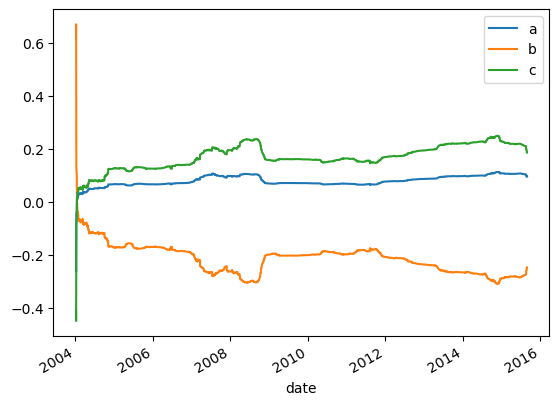

In [51]:
results_calls = rolling_regression(df_calls)
#calls
df_calls[['date','a','b','c']].drop_duplicates("date").sort_values("date").set_index('date').plot()

In [52]:
results_puts = rolling_regression(df_puts)

C:\Users\yigaa\AppData\Local\Temp\ipykernel_5176\1856163905.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['a'] = np.nan
C:\Users\yigaa\AppData\Local\Temp\ipykernel_5176\1856163905.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['b'] = np.nan
C:\Users\yigaa\AppData\Local\Temp\ipykernel_5176\1856163905.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

<Axes: xlabel='date'>

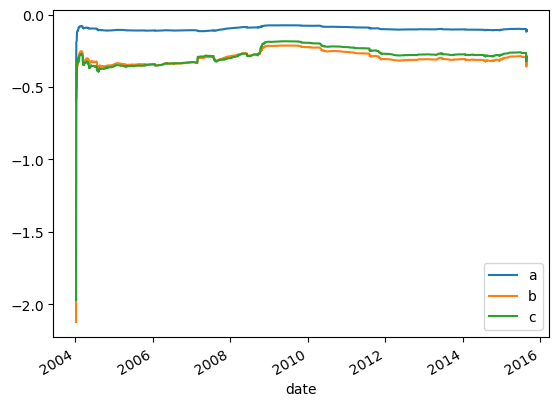

In [56]:
#puts
df_puts[['date','a','b','c']].drop_duplicates("date").sort_values("date").set_index('date').plot()

对冲误差计算
$$
\varepsilon_{MV} = \Delta f - \delta_{BS} \Delta S - \frac{\nu_{BS}}{\sqrt{T}} \frac{\Delta S}{S} \left( \hat{a} + \hat{b} \delta_{BS} + \hat{c} \delta_{BS}^2 \right)
$$



In [58]:
def epsilon_MV(data):
    return data['normalized_price_F_delta']-data["delta"]*data['normalized_price_S_delta']-data['a']*data['X']-data['b']*data['X_delta_BS']-data['c']*data['X_delta_BS_squared'] 
df_puts['epsilon_MV'] = epsilon_MV(df_puts)
df_calls['epsilon_MV'] = epsilon_MV(df_calls)

C:\Users\yigaa\AppData\Local\Temp\ipykernel_5176\3301857476.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_puts['epsilon_MV'] = epsilon_MV(df_puts)
C:\Users\yigaa\AppData\Local\Temp\ipykernel_5176\3301857476.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_calls['epsilon_MV'] = epsilon_MV(df_calls)


In [59]:
def epsilon_bs(data):
    return data['normalized_price_F_delta']-data["delta"]*data['normalized_price_S_delta']
df_puts['epsilon_BS'] = epsilon_bs(df_puts)
df_calls['epsilon_BS'] = epsilon_bs(df_calls)

df_puts

C:\Users\yigaa\AppData\Local\Temp\ipykernel_5176\3590918074.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_puts['epsilon_BS'] = epsilon_bs(df_puts)
C:\Users\yigaa\AppData\Local\Temp\ipykernel_5176\3590918074.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_calls['epsilon_BS'] = epsilon_bs(df_calls)


,date,best_bid,best_offer,impl_volatility,delta,gamma,vega,theta,symbol,cp_flag,...,Vega_over_sqrt_T,X,X_delta_BS,X_delta_BS_squared,y,a,b,c,epsilon_MV,epsilon_BS
225,2010-02-17,6.3,8.2,0.262985,-0.139430,0.002261,82.71461,-97.68786,QSE 100331P1000000,P,...,243.839474,1.029018,-0.143476,0.020005,-0.120621,-0.077919,-0.228105,-0.198446,-0.069199,-0.120621
226,2010-02-18,4.8,6.6,0.258901,-0.116810,0.002042,72.75439,-86.07973,QSE 100331P1000000,P,...,217.076948,1.420047,-0.165876,0.019376,-0.213024,-0.077947,-0.228196,-0.198527,-0.136341,-0.213024
227,2010-02-19,4.1,6.0,0.255245,-0.107981,0.001978,68.07211,-82.30074,QSE 100331P1000000,P,...,205.629609,0.448645,-0.048445,0.005231,-0.113799,-0.077956,-0.228225,-0.198552,-0.088842,-0.113799
229,2010-02-23,5.4,6.4,0.256797,-0.128935,0.002381,72.24676,-97.65686,QSE 100331P1000000,P,...,230.045402,-2.818298,0.363377,-0.046852,0.386675,-0.078033,-0.228488,-0.198817,0.240466,0.386675
230,2010-02-24,3.6,4.5,0.252085,-0.096603,0.001982,58.53431,-78.73563,QSE 100331P1000000,P,...,189.026596,1.819734,-0.175792,0.016982,-0.312620,-0.078068,-0.228607,-0.198934,-0.207366,-0.312620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5681828,2010-02-04,458.0,463.2,0.179328,-0.878224,0.000570,215.40650,-16.91987,SZV.XT,P,...,157.699995,-5.068722,4.451473,-3.909391,0.049197,-0.077991,-0.228332,-0.198616,-0.106173,0.049197
5681829,2010-02-05,457.1,462.5,0.174631,-0.883055,0.000549,202.76260,-17.75871,SZV.XT,P,...,148.552453,0.429137,-0.378952,0.334635,0.000821,-0.077985,-0.228312,-0.198600,0.014227,0.000821
5681831,2010-02-09,452.7,457.3,0.177938,-0.876406,0.000576,217.05830,-17.88577,SZV.XT,P,...,159.495885,2.053071,-1.799324,1.576938,-0.015518,-0.077944,-0.228191,-0.198509,0.046954,-0.015518
5681832,2010-02-10,452.4,457.7,0.177871,-0.877768,0.000575,215.45140,-16.73760,SZV.XT,P,...,158.432351,-0.354501,0.311170,-0.273135,-0.001850,-0.077927,-0.228136,-0.198464,-0.012694,-0.001850


In [61]:

def caculate_Gain(data):
    # 计算 SSE(epsilon_MV)
    SSE_epsilon_MV = (data['epsilon_MV'] ** 2).sum()
    # 计算 SSE(epsilon_BS)
    SSE_epsilon_BS = (data['epsilon_BS'] ** 2).sum()
    Gain = 1 - (SSE_epsilon_MV / SSE_epsilon_BS)
    return Gain



In [63]:
df=pd.concat([df_calls,df_puts],axis=0)
df

,date,best_bid,best_offer,impl_volatility,delta,gamma,vega,theta,symbol,cp_flag,...,Vega_over_sqrt_T,X,X_delta_BS,X_delta_BS_squared,y,a,b,c,epsilon_MV,epsilon_BS
2,2010-02-17,102.8,105.8,0.265298,0.855977,0.002262,83.48813,-76.43914,QSE 100331C1000000,C,...,246.119781,1.038641,0.889053,0.761009,0.033667,0.071011,-0.197532,0.159751,0.013956,0.033667
3,2010-02-18,108.9,111.9,0.260811,0.879375,0.002047,73.45412,-68.07214,QSE 100331C1000000,C,...,219.164730,1.433705,1.260764,1.108684,0.052695,0.070996,-0.197481,0.159715,0.022811,0.052695
4,2010-02-19,110.2,113.2,0.263697,0.881987,0.002003,71.19482,-60.55753,QSE 100331C1000000,C,...,215.062571,0.469226,0.413851,0.365011,0.009847,0.070984,-0.197442,0.159682,-0.000035,0.009847
6,2010-02-23,96.7,99.4,0.261409,0.864375,0.002388,73.75964,-73.24857,QSE 100331C1000000,C,...,234.862657,-2.877314,-2.487079,-2.149769,-0.096551,0.071042,-0.197619,0.159828,-0.040042,-0.096551
7,2010-02-24,105.7,109.7,0.255868,0.898424,0.001999,59.91507,-62.89181,QSE 100331C1000000,C,...,193.485525,1.862660,1.673458,1.503475,0.089686,0.071059,-0.197653,0.159859,0.047747,0.089686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5681828,2010-02-04,458.0,463.2,0.179328,-0.878224,0.000570,215.40650,-16.91987,SZV.XT,P,...,157.699995,-5.068722,4.451473,-3.909391,0.049197,-0.077991,-0.228332,-0.198616,-0.106173,0.049197
5681829,2010-02-05,457.1,462.5,0.174631,-0.883055,0.000549,202.76260,-17.75871,SZV.XT,P,...,148.552453,0.429137,-0.378952,0.334635,0.000821,-0.077985,-0.228312,-0.198600,0.014227,0.000821
5681831,2010-02-09,452.7,457.3,0.177938,-0.876406,0.000576,217.05830,-17.88577,SZV.XT,P,...,159.495885,2.053071,-1.799324,1.576938,-0.015518,-0.077944,-0.228191,-0.198509,0.046954,-0.015518
5681832,2010-02-10,452.4,457.7,0.177871,-0.877768,0.000575,215.45140,-16.73760,SZV.XT,P,...,158.432351,-0.354501,0.311170,-0.273135,-0.001850,-0.077927,-0.228136,-0.198464,-0.012694,-0.001850


In [64]:
df
caculate_Gain(df.query("date>='2007-1-1'"))

0.5263079154021777

In [69]:
#按照delta分组算
#calls
delta_group = df["delta_BS_rounded"].unique()
delta_group.sort()
delta_group

array([-0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0.1,  0.2,
        0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])

In [114]:
fin_ans=delta_group
fin_ans=pd.DataFrame(fin_ans)
fin_ans.columns=['delta_group']
fin_ans['gain']=0
fin_ans

,delta_group,gain
0,-0.9,0
1,-0.8,0
2,-0.7,0
3,-0.6,0
4,-0.5,0
5,-0.4,0
6,-0.3,0
7,-0.2,0
8,-0.1,0
9,0.1,0


In [128]:

for current_group in delta_group:
    index=fin_ans[fin_ans["delta_group"]==current_group].index
    if current_group<0:
        fin_ans.loc[index,'gain']=caculate_Gain(df.query(f"date>='2007-1-1' & delta_BS_rounded=={current_group} & cp_flag=='P'"))
    else:
        fin_ans.loc[index,'gain']=caculate_Gain(df.query(f"date>='2007-1-1' & delta_BS_rounded=={current_group} & cp_flag=='C'"))
fin_ans

,delta_group,gain
0,-0.9,0.612320
1,-0.8,0.570296
2,-0.7,0.600807
3,-0.6,0.551399
4,-0.5,0.539340
5,-0.4,0.537674
6,-0.3,0.567065
7,-0.2,0.534170
8,-0.1,0.476554
9,0.1,0.489546
